# GPU video decoder/encoder

**Author**: [Moto Hira](moto@meta.com)

This tutorial shows how to use NVIDIA's hardware video decoder (NVDEC) and encoder (NVENC) with TorchAudio.

Using hardware encoder/decoder improves the speed of loading and saving certain types of videos.

Using them in TorchAduio requires FFmpeg built with NVENC/NVDEC support. Google Colab has such FFmpeg pre-installed, so you can [run this tutorial on Google Colab](https://colab.research.google.com/drive/1DDah_IaGULEO66CfQWltRqaVheBkiXdN#sandboxMode=true).

If you want to enable GPU decoding/encoding, please refer to [Enabling GPU video decoder/encoder](./build.ffmpeg.html).

## Update PyTorch and TorchAudio with nightly builds

Until PyTorch 2.0 is released, we need to use the nightly builds of PyTorch and TorchAudio.

In [2]:
!pip uninstall -y -q torch torchaudio torchvision torchtext
!pip install --progress-bar off --pre torch torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu117 2> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/nightly/cu117


## Install third party libraries and download assets

In [8]:
!pip3 install --progress-bar off boto3 2> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [10]:
!wget -q -O input.mp4 "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"

## Check the available GPU

In [1]:
!nvidia-smi

Thu Feb  9 15:54:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Check FFmpeg installation

Let's do a quick sanity check to confirm that the FFmpeg we built works.

In [55]:
!ffmpeg -hide_banner -decoders | grep -i cuvid

 V..... h264_cuvid           Nvidia CUVID H264 decoder (codec h264)
 V..... hevc_cuvid           Nvidia CUVID HEVC decoder (codec hevc)
 V..... mjpeg_cuvid          Nvidia CUVID MJPEG decoder (codec mjpeg)
 V..... mpeg1_cuvid          Nvidia CUVID MPEG1VIDEO decoder (codec mpeg1video)
 V..... mpeg2_cuvid          Nvidia CUVID MPEG2VIDEO decoder (codec mpeg2video)
 V..... mpeg4_cuvid          Nvidia CUVID MPEG4 decoder (codec mpeg4)
 V..... vc1_cuvid            Nvidia CUVID VC1 decoder (codec vc1)
 V..... vp8_cuvid            Nvidia CUVID VP8 decoder (codec vp8)
 V..... vp9_cuvid            Nvidia CUVID VP9 decoder (codec vp9)


In [56]:
!ffmpeg -hide_banner -encoders | grep -i nvenc

 V..... h264_nvenc           NVIDIA NVENC H.264 encoder (codec h264)
 V..... nvenc                NVIDIA NVENC H.264 encoder (codec h264)
 V..... nvenc_h264           NVIDIA NVENC H.264 encoder (codec h264)
 V..... nvenc_hevc           NVIDIA NVENC hevc encoder (codec hevc)
 V..... hevc_nvenc           NVIDIA NVENC hevc encoder (codec hevc)


The following command fetches video from remote server, decode with NVDEC (cuvid) and re-encode with NVENC. If this command does not work, then there is an issue with FFmpeg installation, and TorchAudio would not be able to use them either.

In [5]:
!ffmpeg -hide_banner -y -vsync 0 -hwaccel cuvid -hwaccel_output_format cuda -c:v h264_cuvid -resize 360x240 -i "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4" -c:a copy -c:v h264_nvenc -b:v 5M test.mp4

Input #0, mov,mp4,m4a,3gp,3g2,mj2, from 'https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4':
  Metadata:
    major_brand     : mp42
    minor_version   : 512
    compatible_brands: mp42iso2avc1mp41
    encoder         : Lavf58.76.100
  Duration: 00:03:26.04, start: 0.000000, bitrate: 1294 kb/s
    Stream #0:0(eng): Video: h264 (High) (avc1 / 0x31637661), yuv420p(tv, bt709), 960x540 [SAR 1:1 DAR 16:9], 1156 kb/s, 29.97 fps, 29.97 tbr, 30k tbn, 59.94 tbc (default)
    Metadata:
      handler_name    : ?Mainconcept Video Media Handler
    Stream #0:1(eng): Audio: aac (LC) (mp4a / 0x6134706D), 48000 Hz, stereo, fltp, 128 kb/s (default)
    Metadata:
      handler_name    : #Mainconcept MP4 Sound Media Handler
Stream mapping:
  Stream #0:0 -> #0:0 (h264 (h264_cuvid) -> h264 (h264_nvenc))
  Stream #0:1 -> #0:1 (copy)
Press [q] to stop, [?] for help
Output #0, mp4, to 'test.mp4':
  Metadata:


## Check the TorchAudio / FFmpeg integration

In [6]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

from torchaudio.io import StreamReader, StreamWriter

2.0.0.dev20230209+cu117
2.0.0.dev20230208+cu117


In [61]:
from torchaudio.utils import ffmpeg_utils

print("Library versions:")
print(ffmpeg_utils.get_versions())
print("\nBuild config:")
print(ffmpeg_utils.get_build_config())
print("\nDecoders:")
print([k for k in ffmpeg_utils.get_video_decoders().keys() if "cuvid" in k])
print("\nEncoders:")
print([k for k in ffmpeg_utils.get_video_encoders().keys() if "nvenc" in k])

Library versions:
{'libavutil': (56, 31, 100), 'libavcodec': (58, 54, 100), 'libavformat': (58, 29, 100), 'libavfilter': (7, 57, 100), 'libavdevice': (58, 8, 100)}

Build config:
--prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-

## Benchmarking GPU Encoding and Decoding

Now that FFmpeg and the resulting libraries are ready to use, we test NVDEC/NVENC with TorchAudio. For the basics of TorchAudio's streaming APIs, please refer to [Media I/O tutorials](https://pytorch.org/audio/main/tutorials.io.html).

In [7]:
import time
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Benchmark NVDEC with `StreamReader`

First we test hardware decoding, and we fetch video from multiple locations (local file, network file, AWS S3) and use NVDEC to decod them.

In [9]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config

print(boto3.__version__)

1.26.67


First, we define the functions we'll use for testing.

Funcion `test_decode` decodes the given source from start to end, and it reports the elapsed time, and returns one image frmae as a sample.

In [11]:
result = torch.zeros((4, 2))
samples = [[None, None] for _ in range(4)]


def test_decode(src, config, i_sample):
  print("=" * 40)
  print("* Configuration:", config)
  print("* Source:", src)
  print("=" * 40)

  t0 = time.monotonic()
  s = StreamReader(src)
  s.add_video_stream(5, **config)

  num_frames = 0
  for i, (chunk, ) in enumerate(s.stream()):
    if i == 0:
      print(' - Chunk:', chunk.shape, chunk.device, chunk.dtype)
    if i == i_sample:
      sample = chunk[0]
    num_frames += chunk.shape[0]
  elapsed = time.monotonic() - t0

  print()
  print(f" - Processed {num_frames} frames.")
  print(f" - Elapsed: {elapsed} seconds.")
  print()

  return elapsed, sample

### Decode MP4 from local file

For the first test, we compare the time it takes for CPU and NVDEC to decode 250MB of MP4 video.

In [12]:
local_src = "input.mp4"

i_sample = 520

#### CPU

In [13]:
cpu_conf = {
    "decoder": "h264",  # CPU decoding
}

elapsed, sample = test_decode(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 43.65067997 seconds.



In [14]:
result[0, 0] = elapsed
samples[0][0] = sample

#### CUDA

In [15]:
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

elapsed, sample = test_decode(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 5.754925530000008 seconds.



In [16]:
result[0, 1] = elapsed
samples[0][1] = sample

### Decode MP4 from network

Let's run the same test on the source retrieved via network on-the-fly.

In [17]:
network_src = "https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"
i_sample = 750

#### CPU

In [18]:
elapsed, sample = test_decode(network_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 33.74701378400002 seconds.



In [19]:
result[1, 0] = elapsed
samples[1][0] = sample

#### CUDA

In [20]:
elapsed, sample = test_decode(network_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: https://download.pytorch.org/torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 15.769149663000007 seconds.



In [21]:
result[1, 1] = elapsed
samples[1][1] = sample

### Decode MP4 directly from S3

Using file-like object input, we can fetch a video stored on AWS S3 and decode it without saving it on local file system.

In [22]:
bucket = "pytorch"
key = "torchaudio/tutorial-assets/stream-api/NASAs_Most_Scientifically_Complex_Space_Observatory_Requires_Precision-MP4_small.mp4"

s3_client = boto3.client("s3", config=Config(signature_version=UNSIGNED))
i_sample = 115

#### Defining Helper class

StreamReader supports file-like objects with `read` method. In addition to this,
if the file-like object has `seek` method, StreamReader attempts to use it for more reliable detection of media formats.

However, the seek method of `boto3`'s S3 client response object only raises errors to let users know that seek operation is not supported. Therefore we wrap it with a class that does not have `seek` method. This way, StreamReader won't try to use the `seek` method.

**Note**

Due to the nature of streaming, when using file-like object without seek method, some formats are not supported. For example, MP4 formats contain metadata at the beginning of file or at the end. If metadata is located at the end, without `seek` method, StreamReader cannot decode streams.

In [23]:
# Wrapper to hide the native `seek` method of boto3, which
# only raises an error.
class UnseekableWrapper:
  def __init__(self, obj):
    self.obj = obj

  def read(self, n):
    return self.obj.read(n)

  def __str__(self):
    return str(self.obj)

#### CPU

In [24]:
response = s3_client.get_object(Bucket=bucket, Key=key)
src = UnseekableWrapper(response["Body"])
elapsed, sample = test_decode(src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264'}
* Source: <botocore.response.StreamingBody object at 0x7fcc9b0b83a0>
 - Chunk: torch.Size([5, 3, 540, 960]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 29.465254898000012 seconds.



In [25]:
result[2, 0] = elapsed
samples[2][0] = sample

#### CUDA

In [26]:
response = s3_client.get_object(Bucket=bucket, Key=key)
src = UnseekableWrapper(response["Body"])
elapsed, sample = test_decode(src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'hw_accel': 'cuda:0'}
* Source: <botocore.response.StreamingBody object at 0x7fcc9b0b8730>
 - Chunk: torch.Size([5, 3, 540, 960]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 3.475249672000018 seconds.



In [27]:
result[2, 1] = elapsed
samples[2][1] = sample

### Decoding and resizing

In the next test, we add preprocessing. NVDEC supports several preprocessing schemes, which are also performed on the chosen hardware. For CPU, we apply the same kind of software preprocessing through FFmpeg's filter graph.

In [28]:
i_sample = 1085

#### CPU

In [29]:
cpu_conf = {
    "decoder": "h264",  # CPU decoding
    "filter_desc": "scale=360:240",  # Software filter
}

elapsed, sample = test_decode(local_src, cpu_conf, i_sample)

* Configuration: {'decoder': 'h264', 'filter_desc': 'scale=360:240'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cpu torch.uint8

 - Processed 6175 frames.
 - Elapsed: 17.26762169899996 seconds.



In [30]:
result[3, 0] = elapsed
samples[3][0] = sample

#### CUDA

In [31]:
cuda_conf = {
    "decoder": "h264_cuvid",  # Use CUDA HW decoder
    "decoder_option": {
        "resize": "360x240",  # Then apply HW preprocessing (resize)
    },
    "hw_accel": "cuda:0",  # Then keep the memory on CUDA:0
}

elapsed, sample = test_decode(local_src, cuda_conf, i_sample)

* Configuration: {'decoder': 'h264_cuvid', 'decoder_option': {'resize': '360x240'}, 'hw_accel': 'cuda:0'}
* Source: input.mp4
 - Chunk: torch.Size([5, 3, 240, 360]) cuda:0 torch.uint8

 - Processed 6175 frames.
 - Elapsed: 15.233130482000035 seconds.



In [32]:
result[3, 1] = elapsed
samples[3][1] = sample

### Results

The following table summarizes the time it took to decode the same media with CPU and NVDEC.
We see significant speedup with NVDEC.

In [33]:
res = pd.DataFrame(
    result.numpy(),
    index=["Decoding (local file)", "Decoding (network file)", "Decoding (file-like object, S3)", "Decoding + Resize"],
    columns=["CPU", "NVDEC"],
)
print(res)

                                       CPU      NVDEC
Decoding (local file)            43.650681   5.754926
Decoding (network file)          33.747013  15.769150
Decoding (file-like object, S3)  29.465256   3.475250
Decoding + Resize                17.267622  15.233130


The following code shows some frames generated by CPU decoding and NVDEC. They produce seemingly identical results.

In [34]:
def yuv_to_rgb(img):
  img = img.cpu().to(torch.float)
  y = img[..., 0, :, :]
  u = img[..., 1, :, :]
  v = img[..., 2, :, :]

  y /= 255
  u = u / 255 - 0.5
  v = v / 255 - 0.5

  r = y + 1.14 * v
  g = y + -0.396 * u - 0.581 * v
  b = y + 2.029 * u

  rgb = torch.stack([r, g, b], -1)
  rgb = (rgb * 255).clamp(0, 255).to(torch.uint8)
  return rgb.numpy()

[]

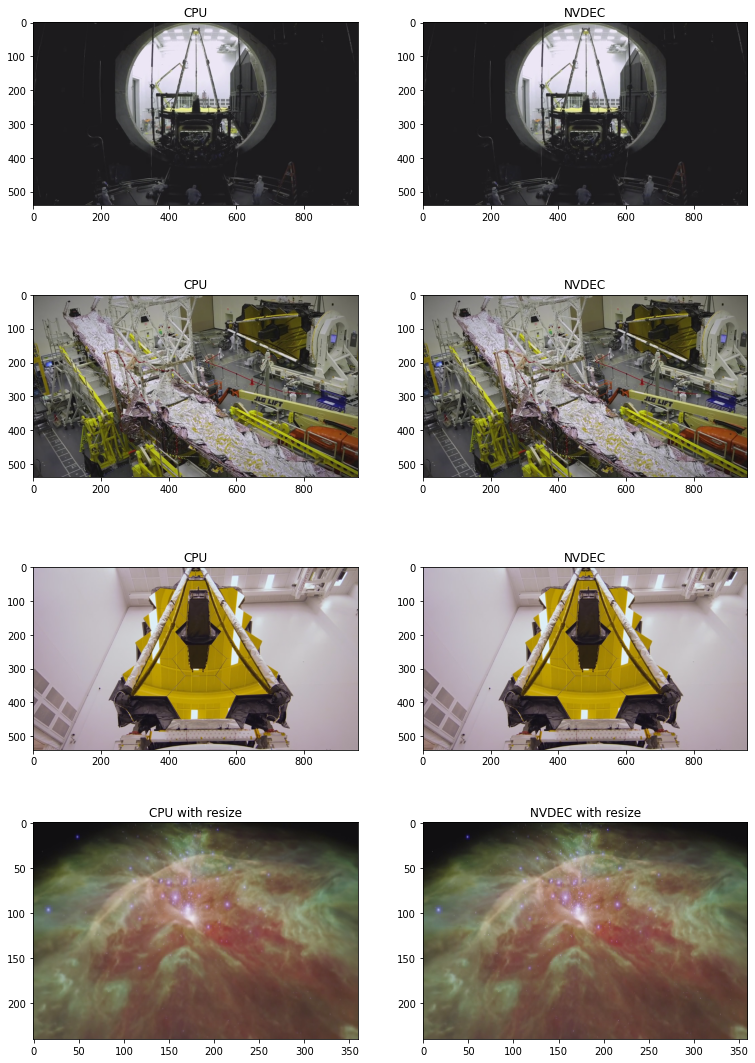

In [35]:
f, axs = plt.subplots(4, 2, figsize=[12.8, 19.2])
for i in range(4):
  for j in range(2):
    axs[i][j].imshow(yuv_to_rgb(samples[i][j]))
    axs[i][j].set_title(
        f"{'CPU' if j == 0 else 'NVDEC'}{' with resize' if i == 3 else ''}")
plt.plot(block=False)

## Benchmark NVENC with `StreamWriter`

Next, we benchmark encoding speed with StreamWriter and NVENC.



In [36]:
def test_encode(data, dst, **config):
  print("=" * 40)
  print("* Configuration:", config)
  print("* Destination:", dst)
  print("=" * 40)

  t0 = time.monotonic()
  s = StreamWriter(dst)
  s.add_video_stream(**config)
  with s.open():
    s.write_video_chunk(0, data)
  elapsed = time.monotonic() - t0

  print()
  print(f" - Processed {len(data)} frames.")
  print(f" - Elapsed: {elapsed} seconds.")
  print()
  return elapsed

result = torch.zeros((3, 3))

We use ``StreamReader`` to generate test data.

In [37]:
def get_data(frame_rate, height, width, format, duration=15):
  src = f"testsrc2=rate={frame_rate}:size={width}x{height}:duration={duration}"
  s = StreamReader(src=src, format="lavfi")
  s.add_basic_video_stream(-1, format=format)
  s.process_all_packets()
  video, = s.pop_chunks()
  return video

### Encode MP4 - 360P

For the first test, we compare the time it takes for CPU and NVENC to encode 15 seconds of video with small resolution.

In [38]:
pict_config = {
    "height": 360,
    "width": 640,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [39]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 0] = test_encode(video, "360p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 360p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 6.311792093000008 seconds.



#### CUDA (from CPU Tensor)

Now we test NVENC. This time, the data is sent from CPU memory to GPU memory as part of encoding.

In [40]:
encode_config = {
    "encoder": "h264_nvenc",  # Use NVENC
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},  # Run encoding on the cuda:0 device
}

result[1, 0] = test_encode(video, "360p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}}
* Destination: 360p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 0.5352325430000064 seconds.



#### CUDA (from CUDA Tensor)

If the data is already present on CUDA, then we can pass it to GPU encoder directly.

In [41]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",  # GPU Encoder
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},  # Run encoding on the cuda:0 device
    "hw_accel": device,  # Data comes from cuda:0 device
}

result[2, 0] = test_encode(video.to(torch.device(device)), "360p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 360, 'width': 640, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 360p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 0.7045466739999711 seconds.



### Encode MP4 - 720P

Let's run the same tests on video with larger resolution.

In [42]:
pict_config = {
    "height": 720,
    "width": 1280,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [43]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 1] = test_encode(video, "720p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 720p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 14.017578084000036 seconds.



#### CUDA (from CPU Tensor)

In [44]:
encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
}

result[1, 1] = test_encode(video, "720p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p'}
* Destination: 720p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 0.9797491379999883 seconds.



#### CUDA (from CUDA Tensor)

In [45]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},
    "hw_accel": device,
}

result[2, 1] = test_encode(video.to(torch.device(device)), "720p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 720, 'width': 1280, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 720p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 0.7259890020000057 seconds.



### Encode MP4 - 1080P

We make the video with even larger.

In [46]:
pict_config = {
    "height": 1080,
    "width": 1920,
    "frame_rate": 30000/1001,
    "format": "yuv444p",
}

video = get_data(**pict_config)

#### CPU

In [47]:
encode_config = {
    "encoder": "libx264",
    "encoder_format": "yuv444p",
}

result[0, 2] = test_encode(video, "1080p_cpu.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'libx264', 'encoder_format': 'yuv444p'}
* Destination: 1080p_cpu.mp4

 - Processed 450 frames.
 - Elapsed: 29.441768007999997 seconds.



#### CUDA (from CPU Tensor)

In [48]:
encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
}

result[1, 2] = test_encode(video, "1080p_cuda.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p'}
* Destination: 1080p_cuda.mp4

 - Processed 450 frames.
 - Elapsed: 1.5768605540000067 seconds.



#### CUDA (from CUDA Tensor)

In [49]:
device = "cuda:0"

encode_config = {
    "encoder": "h264_nvenc",
    "encoder_format": "yuv444p",
    "encoder_option": {"gpu": "0"},
    "hw_accel": device,
}

result[2, 2] = test_encode(video.to(torch.device(device)), "1080p_cuda_hw.mp4", **pict_config, **encode_config)

* Configuration: {'height': 1080, 'width': 1920, 'frame_rate': 29.97002997002997, 'format': 'yuv444p', 'encoder': 'h264_nvenc', 'encoder_format': 'yuv444p', 'encoder_option': {'gpu': '0'}, 'hw_accel': 'cuda:0'}
* Destination: 1080p_cuda_hw.mp4

 - Processed 450 frames.
 - Elapsed: 1.4002963130000126 seconds.



### Result

Here is the result.

In [50]:
labels = ["CPU", "CUDA (from CPU Tensor)", "CUDA (from CUDA Tensor)"]
columns = ["360P", "720P", "1080P"]
res = pd.DataFrame(
    result.numpy(),
    index=labels,
    columns=columns,
)
print(res)

                             360P       720P      1080P
CPU                      6.311792  14.017578  29.441769
CUDA (from CPU Tensor)   0.535233   0.979749   1.576861
CUDA (from CUDA Tensor)  0.704547   0.725989   1.400296


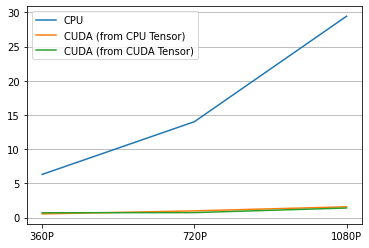

In [51]:
plt.plot(result.T)
plt.legend(labels)
plt.xticks([i for i in range(3)], columns)
plt.grid(visible=True, axis='y')

The resulting videos look like the following.

In [52]:
from IPython.display import HTML

HTML('''
<div>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cpu.mp4" type="video/mp4">
  </video>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cuda.mp4" type="video/mp4">
  </video>
  <video width=360 controls autoplay>
    <source src="https://download.pytorch.org/torchaudio/tutorial-assets/streamwriter_360p_cuda_hw.mp4" type="video/mp4">
  </video>
</div>
''')

## Conclusion

We looked at how to build FFmpeg libraries with NVDEC/NVENC support and use them from TorchAudio. NVDEC/NVENC provide significant speed up when saving/loading a video.